In [87]:
import csv
import math
import matplotlib.pyplot
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.utils import np_utils
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm_notebook
%matplotlib inline

In [88]:
# maximum Accuracy
maxAcc = 0.0
# maximum iterations
maxIter = 0
# generalization rate
C_Lambda = 0.02

# percentage of data used for Training, Validation and Testing
TrainingPercent = 80
ValidationPercent = 10
TestPercent = 10

#number of basis functions
M = 10
# design matrix
PHI = []
IsSynthetic = False

In [89]:
# taking 80% of target vectors for Training
def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    return t

# taking 80% of dataMAtrix for Training
def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    d2 = rawData[:,0:T_len]
    return d2

# taking 10% of dataMatrix for Validation set and Training set
def GenerateValData(rawData, ValPercent, TrainingCount):
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End]  
    return dataMatrix

# taking 10% of target vectors for Validation set and Training set
def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    return t

# the function is used generate the co-variance matrix 
def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic):
    BigSigma    = np.zeros((len(Data),len(Data)))
    DataT       = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))        
    varVect     = []
    for i in range(0,len(DataT[0])):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        # inserting variance of each row into the varVect 
        varVect.append(np.var(vct))    
    # inserting variance of each row into the diagonal of the BigSigma matrix 
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j]+0.2
    # dot product is done with 3 or 200 for scaling the co-variance matrix
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(200,BigSigma)
    return BigSigma

# generating scalar values for design matrix
def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

# calling GetScalar to get scalar values for design matrix
def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

# used to get the design matrix for the algorithm from Radial Basis Out functions
def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma)
    # calling the GetRadialBasisOut for the scalar values of the design matrix
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    return PHI

# used to find and get weight for the closed form
def GetWeightsClosedForm(PHI, T, Lambda):
    Lambda_I = np.identity(len(PHI[0]))
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda
    PHI_T       = np.transpose(PHI)
    PHI_SQR     = np.dot(PHI_T,PHI)
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR)
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI)
    INTER       = np.dot(PHI_SQR_INV, PHI_T)
    W           = np.dot(INTER, T)
    return W

# used to get predicted output values (labels)
def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    return Y

# used to get the Erms values and Accuracy rate
def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

## Fetching and Preparing Human Concatenation Dataset

In [90]:
images=[]
pairs=[]
features=[]
RawTarget=[]
RawData=[]

with open('human_features.csv') as f:
    reader=csv.reader(f)
    for row in reader:
        images.append(row[0])
        arr=[]
        for col in row[1:]:
            arr.append(int(col))
        features.append(arr)

with open('same_pairs.csv') as f:
    reader=csv.reader(f)
    for row in reader:
        pairs.append(row[:2])
        RawTarget.append(int(row[2]))

with open('diffn_pairs.csv') as f:
    reader=csv.reader(f)
    count=0
    for row in reader:
        pairs.append(row[:2])
        RawTarget.append(int(row[2]))
        count=count+1
        if count>791:
            break

for pair in pairs:
    feat1=features[images.index(pair[0])] + features[images.index(pair[1])]
    RawData.append(feat1)
    
combined=list(zip(RawData,RawTarget))
random.shuffle(combined)
random.shuffle(combined)
random.shuffle(combined)
RawData[:],RawTarget[:]=zip(*combined)
    
RawData=np.transpose(RawData)

## Prepare Human Training Data

In [91]:
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)

(1267,)
(18, 1267)


## Prepare Human Validation Data

In [92]:
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

(158,)
(18, 158)


## Prepare Human Test Data

In [93]:
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(ValDataAct.shape)
print(ValData.shape)

(158,)
(18, 158)


##  Finding Weights for Human DataSet

In [94]:
ErmsArr = []
AccuracyArr = []

kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
Mu = kmeans.cluster_centers_

# Training co-variance matrix
BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
# design matrix
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
# Training weights
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
# test design matrix
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
# validation design matrix
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)

In [95]:
print(Mu.shape)
print(BigSigma.shape)
print(TRAINING_PHI.shape)
print(W.shape)
print(VAL_PHI.shape)
print(TEST_PHI.shape)

(10, 18)
(18, 18)
(1267, 10)
(10,)
(158, 10)
(157, 10)


## Gradient Descent solution for Linear Regression

In [96]:
W_Now        = np.dot(220, W)
La           = 10
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []
Acc_Val      = []
Acc_TR       = []
Acc_Test     = []

for i in range(0,1200):
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    # error differential value
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    # removing error differential from current weights
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
    # multiplying learning rate with error
    Delta_W       = -np.dot(C_Lambda ,Delta_E)
    # updating the weights
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    Acc_TR.append(float(Erms_TR.split(',')[0]))
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    Acc_Val.append(float(Erms_Val.split(',')[0]))
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test     = GetErms(TEST_OUT,TestDataAct)
    Acc_Test.append(float(Erms_Test.split(',')[0]))
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))

## ## Gradient Descent solution for Linear Regression Using GSC DataSet

In [97]:
print ('----------Gradient Descent Solution for Human Data--------------------')
print ("M = ",M,"\nLambda  = ",C_Lambda,"\neta=",La)
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))
print ("Accuracy TR      = " + str(np.around(max(Acc_TR),5)))
print ("Accuracy Val     = " + str(np.around(max(Acc_Val),5)))
print ("Accuracy Test    = " + str(np.around(max(Acc_Test),5)))

----------Gradient Descent Solution for Human Data--------------------
M =  10 
Lambda  =  0.02 
eta= 10
E_rms Training   = 0.38852
E_rms Validation = 0.41914
E_rms Testing    = 0.42589
Accuracy TR      = 77.66377
Accuracy Val     = 75.94937
Accuracy Test    = 73.24841


# Encoding Data for Neural Networking

In [98]:
def encodeLabel(labels):
    
    processedLabel = []
    
    for labelInstance in labels:
        if(labelInstance == 0):
            processedLabel.append([0])
        elif(labelInstance == 1):
            processedLabel.append([1])

    return np_utils.to_categorical(np.array(processedLabel),2)

def encodeData(Data):
    
    return np.array(Data)

## Processing DataSet for NN

In [99]:
# Process Human Dataset
processedTrainingData  = encodeData(np.transpose(RawData)[:1400])
processedTrainingLabel = encodeLabel(RawTarget[:1400])
processedTestingData   = np.array(np.transpose(RawData)[1400:])
processedTestingLabel  = encodeLabel(RawTarget[1400:])

In [100]:
outputTensor = tf.placeholder(tf.float32, [None, 2])
inputTensor  = tf.placeholder(tf.float32, [None, 18])

In [101]:
NUM_HIDDEN_NEURONS_LAYER_1 = 100
LEARNING_RATE = 0.000075

# Initializing the weights to Normal Distribution
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape,stddev=0.01))

# Initializing the input to hidden layer weights
input_hidden_weights  = init_weights([18, NUM_HIDDEN_NEURONS_LAYER_1])
# Initializing the hidden to output layer weights
hidden_output_weights = init_weights([NUM_HIDDEN_NEURONS_LAYER_1, 2])

# Computing values at the hidden layer
hidden_layer = tf.nn.relu(tf.matmul(inputTensor, input_hidden_weights))
# Computing values at the output layer
output_layer = tf.matmul(hidden_layer, hidden_output_weights)

# Defining Error Function
error_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output_layer, labels=outputTensor))

# Defining Learning Algorithm and Training Parameters
training = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(error_function)

# Prediction Function
prediction = tf.argmax(output_layer, 1)

In [102]:
NUM_OF_EPOCHS = 1500
BATCH_SIZE = 120

training_accuracy = []

with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    
    for epoch in tqdm_notebook(range(NUM_OF_EPOCHS)):
        
        #Shuffle the Training Dataset at each epoch
        p = np.random.permutation(range(len(processedTrainingData)))
        processedTrainingData  = processedTrainingData[p]
        processedTrainingLabel = processedTrainingLabel[p]
        
        # Start batch training
        for start in range(0, len(processedTrainingData), BATCH_SIZE):
            end = start + BATCH_SIZE
            sess.run(training, feed_dict={inputTensor: processedTrainingData[start:end], 
                                          outputTensor: processedTrainingLabel[start:end]})
        # Training accuracy for an epoch
        training_accuracy.append(np.mean(np.argmax(processedTrainingLabel, axis=1) ==
                             sess.run(prediction, feed_dict={inputTensor: processedTrainingData,
                                                             outputTensor: processedTrainingLabel})))
    # Testing
    predictedTestLabel = sess.run(prediction, feed_dict={inputTensor: processedTestingData})

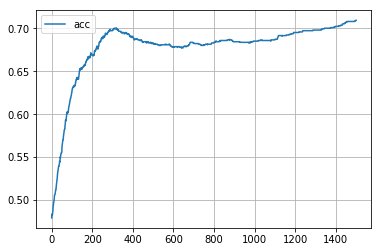

In [103]:
df = pd.DataFrame()
df['acc'] = training_accuracy
df.plot(grid=True)

In [104]:
def decodeLabel(encodedLabel):
    if encodedLabel == 0:
        return 0
    elif encodedLabel == 1:
        return 1

In [105]:
wrong   = 0
right   = 0

for i,j in zip(processedTestingLabel,predictedTestLabel):

    if np.argmax(i) == j:
        right = right + 1
    else:
        wrong = wrong + 1

print("Errors: " + str(wrong), " Correct :" + str(right))

print("Testing Accuracy: " + str(right/(right+wrong)*100))

Errors: 60  Correct :123
Testing Accuracy: 67.21311475409836


## Logistic Regression

In [106]:
TrainingData   = np.transpose(RawData)[:1400]
TrainingTarget = np.array(RawTarget[:1400])
TestingData    = np.transpose(RawData)[1400:]
TestingTarget  = np.array(RawTarget[1400:])

In [107]:
class LogisticRegression:
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True, verbose=False):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
        self.verbose = verbose
    
    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        
        # weights initialization
        self.theta = np.zeros(X.shape[1])
        
        for i in range(self.num_iter):
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / y.size
            self.theta -= self.lr * gradient
            
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            loss = self.__loss(h, y)
                
            if(self.verbose ==True and i % 10000 == 0):
                print(loss)
    
    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)
    
        return self.__sigmoid(np.dot(X, self.theta))
    
    def predict(self, X):
        return self.predict_prob(X).round()

In [108]:
model = LogisticRegression(lr=0.1, num_iter=3000)

In [109]:
%time model.fit(TrainingData, TrainingTarget)

Wall time: 823 ms


In [110]:
preds = model.predict(TestingData)
(preds == TestingTarget).mean()

0.90710382513661203

# Preparing Subtraction DataSet

## Linear Regression

In [111]:
images=[]
pairs=[]
features=[]
RawTarget=[]
RawData=[]

with open('human_features.csv') as f:
    reader=csv.reader(f)
    for row in reader:
        images.append(row[0])
        arr=[]
        for col in row[1:]:
            arr.append(int(col))
        features.append(arr)

with open('same_pairs.csv') as f:
    reader=csv.reader(f)
    for row in reader:
        pairs.append(row[:2])
        RawTarget.append(int(row[2]))

with open('diffn_pairs.csv') as f:
    reader=csv.reader(f)
    count=0
    for row in reader:
        pairs.append(row[:2])
        RawTarget.append(int(row[2]))
        count=count+1
        if count>791:
            break

for pair in pairs:
    feat1=features[images.index(pair[0])] 
    feat2=features[images.index(pair[1])]
    feat=[]
    for i in range(len(feat1)):
        feat.append(abs(feat1[i]-feat2[i]))
    RawData.append(feat)
    
combined=list(zip(RawData,RawTarget))
random.shuffle(combined)
random.shuffle(combined)
random.shuffle(combined)
RawData[:],RawTarget[:]=zip(*combined)
    
RawData=np.transpose(RawData)

In [112]:
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)

(1267,)
(9, 1267)


In [113]:
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

(158,)
(9, 158)


In [114]:
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(ValDataAct.shape)
print(ValData.shape)

(158,)
(9, 158)


In [115]:
ErmsArr = []
AccuracyArr = []

kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
Mu = kmeans.cluster_centers_

# Training co-variance matrix
BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
# design matrix
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
# Training weights
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
# test design matrix
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
# validation design matrix
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)

In [116]:
W_Now        = np.dot(220, W)
La           = 10
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []
Acc_Val      = []
Acc_TR       = []
Acc_Test     = []

for i in range(0,800):
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    # error differential value
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    # removing error differential from current weights
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
    # multiplying learning rate with error
    Delta_W       = -np.dot(C_Lambda ,Delta_E)
    # updating the weights
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    Acc_TR.append(float(Erms_TR.split(',')[0]))
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    Acc_Val.append(float(Erms_Val.split(',')[0]))
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test     = GetErms(TEST_OUT,TestDataAct)
    Acc_Test.append(float(Erms_Test.split(',')[0]))
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))

In [117]:
print ('----------Gradient Descent Solution for Human Data--------------------')
print ("M = ",M,"\nLambda  = ",C_Lambda,"\neta=",La)
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))
print ("Accuracy TR      = " + str(np.around(max(Acc_TR),5)))
print ("Accuracy Val     = " + str(np.around(max(Acc_Val),5)))
print ("Accuracy Test    = " + str(np.around(max(Acc_Test),5)))

----------Gradient Descent Solution for Human Data--------------------
M =  10 
Lambda  =  0.02 
eta= 10
E_rms Training   = 0.45469
E_rms Validation = 0.47274
E_rms Testing    = 0.43335
Accuracy TR      = 71.90213
Accuracy Val     = 72.1519
Accuracy Test    = 72.61146


# Neural Networks

In [118]:
# Process Human Dataset
processedTrainingData  = encodeData(np.transpose(RawData)[:1400])
processedTrainingLabel = encodeLabel(RawTarget[:1400])
processedTestingData   = np.array(np.transpose(RawData)[1400:])
processedTestingLabel  = encodeLabel(RawTarget[1400:])

In [119]:
outputTensor = tf.placeholder(tf.float32, [None, 2])
inputTensor  = tf.placeholder(tf.float32, [None, 9])

In [120]:
NUM_HIDDEN_NEURONS_LAYER_1 = 100
LEARNING_RATE = 0.000025

# Initializing the weights to Normal Distribution
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape,stddev=0.01))

# Initializing the input to hidden layer weights
input_hidden_weights  = init_weights([9, NUM_HIDDEN_NEURONS_LAYER_1])
# Initializing the hidden to output layer weights
hidden_output_weights = init_weights([NUM_HIDDEN_NEURONS_LAYER_1, 2])

# Computing values at the hidden layer
hidden_layer = tf.nn.relu(tf.matmul(inputTensor, input_hidden_weights))
# Computing values at the output layer
output_layer = tf.matmul(hidden_layer, hidden_output_weights)

# Defining Error Function
error_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output_layer, labels=outputTensor))

# Defining Learning Algorithm and Training Parameters
training = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(error_function)

# Prediction Function
prediction = tf.argmax(output_layer, 1)

In [121]:
NUM_OF_EPOCHS = 1500
BATCH_SIZE = 120

training_accuracy = []

with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    
    for epoch in tqdm_notebook(range(NUM_OF_EPOCHS)):
        
        #Shuffle the Training Dataset at each epoch
        p = np.random.permutation(range(len(processedTrainingData)))
        processedTrainingData  = processedTrainingData[p]
        processedTrainingLabel = processedTrainingLabel[p]
        
        # Start batch training
        for start in range(0, len(processedTrainingData), BATCH_SIZE):
            end = start + BATCH_SIZE
            sess.run(training, feed_dict={inputTensor: processedTrainingData[start:end], 
                                          outputTensor: processedTrainingLabel[start:end]})
        # Training accuracy for an epoch
        training_accuracy.append(np.mean(np.argmax(processedTrainingLabel, axis=1) ==
                             sess.run(prediction, feed_dict={inputTensor: processedTrainingData,
                                                             outputTensor: processedTrainingLabel})))
    # Testing
    predictedTestLabel = sess.run(prediction, feed_dict={inputTensor: processedTestingData})

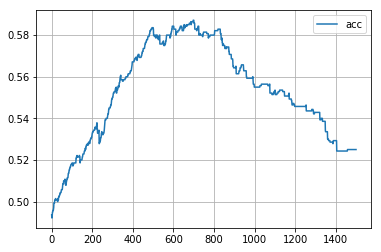

In [122]:
df = pd.DataFrame()
df['acc'] = training_accuracy
df.plot(grid=True)

In [123]:
def decodeLabel(encodedLabel):
    if encodedLabel == 0:
        return 0
    elif encodedLabel == 1:
        return 1

In [124]:
wrong   = 0
right   = 0

for i,j in zip(processedTestingLabel,predictedTestLabel):

    if np.argmax(i) == j:
        right = right + 1
    else:
        wrong = wrong + 1

print("Errors: " + str(wrong), " Correct :" + str(right))

print("Testing Accuracy: " + str(right/(right+wrong)*100))

Errors: 90  Correct :93
Testing Accuracy: 50.81967213114754


# Logistic Regression

In [125]:
TrainingData   = np.transpose(RawData)[:1400]
TrainingTarget = np.array(RawTarget[:1400])
TestingData    = np.transpose(RawData)[1400:]
TestingTarget  = np.array(RawTarget[1400:])

In [126]:
class LogisticRegression:
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True, verbose=False):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
        self.verbose = verbose
    
    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        
        # weights initialization
        self.theta = np.zeros(X.shape[1])
        
        for i in range(self.num_iter):
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / y.size
            self.theta -= self.lr * gradient
            
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            loss = self.__loss(h, y)
                
            if(self.verbose ==True and i % 10000 == 0):
                print(loss)
    
    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)
    
        return self.__sigmoid(np.dot(X, self.theta))
    
    def predict(self, X):
        return self.predict_prob(X).round()

In [127]:
model = LogisticRegression(lr=0.1, num_iter=3000)

In [128]:
%time model.fit(TrainingData, TrainingTarget)

Wall time: 773 ms


In [129]:
preds = model.predict(TestingData)
(preds == TestingTarget).mean()

0.8306010928961749